In [ ]:
from lambeq import BobcatParser, AtomicType, CircuitAnsatz, IQPAnsatz
from lambeq import Rewriter, remove_cups
from lambeq import Dataset, QuantumTrainer, SPSAOptimizer, NumpyModel, TketModel  
from lambeq.core.utils import flatten

from pytket.extensions.qiskit import tk_to_qiskit, AerBackend

import os
import warnings
import numpy as np
import matplotlib.pyplot as plt
import functions 

warnings.filterwarnings('ignore')
os.environ['TOKENIZERS_PARALLELISM'] = 'false'

In [2]:
BATCH_SIZE = 30  ## batch size of training data if don't want to use full training dataset at once
EPOCHS = 400    ## number of epochs for training the model
SEED = 2

##  Read the data file and extract sentence pairs and lablels

In [3]:
def read_data(filename):
    labels, sentence_pairs = [], []
    with open(filename) as f:
        for line in f:
            l = line.strip().split(',')
            labels.append([int(l[2]), 1-int(l[2])]) ## not sure why two labels are required
            sentence_pairs.append([l[0]]+ [l[1]])
            
    return labels, sentence_pairs

labels, sentence_pairs = read_data('datasets/MC1.txt')
train_labels, train_data = labels[:80], sentence_pairs[:80]  # for now first 60 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels, test_data = labels[80:], sentence_pairs[80:]    # rest is test data

## Create a random dataset from the given data by shuffling to check the model yourself.

In [4]:
sentence_pairs1, labels1  = Dataset.shuffle_data(sentence_pairs, labels) ## returns data, target

train_labels, train_data = labels1[:80], sentence_pairs1[:80]  # for now first 80 data set is used as training data
#dev_labels, dev_data = labels[60:80], sentence_pairs[60:80]  # next 20 data set is validation data
test_labels, test_data = labels1[80:], sentence_pairs1[80:]    # rest is test data

## Create sentence diagrams

In [4]:
parser = BobcatParser(verbose='suppress')  ## to select particular type of words like nouns use 'root_cats' parameter

raw_train_diagrams = [parser.sentences2diagrams(d) for d in train_data] # can send list of list of str to the function
#raw_dev_diagrams = [parser.sentences2diagrams(d) for d in dev_data]
raw_test_diagrams = [parser.sentences2diagrams(d) for d in test_data]

## Simplify and check for completed diagrams

In [7]:
## First filter out those diagrams which could not be parsed

## before filtering
#print(len(raw_train_diagrams), len(raw_dev_diagrams), len(raw_test_diagrams))

train_diagrams, train_labels_final = [], []
dev_diagrams, dev_labels_final = [], []
test_diagrams, test_labels_final = [], []

for diagram, label in zip(raw_train_diagrams, train_labels):
    if diagram[0] is not None and diagram[1] is not None:
        train_diagrams.append(remove_cups(diagram))
        train_labels_final.append(label)
        
# for diagram, label in zip(raw_dev_diagrams, dev_labels):
#     if diagram[0] is not None and diagram[1] is not None:
#         dev_diagrams.append(remove_cups(diagram))
#         dev_labels_final.append(label)

for diagram, label in zip(raw_test_diagrams, test_labels):
    if diagram[0] is not None and diagram[1] is not None:
        test_diagrams.append(remove_cups(diagram))
        test_labels_final.append(label)

print(len(train_diagrams), len(dev_diagrams), len(test_diagrams))

80 0 20


## Craete a different ansatz by changing rotation gates in the default IQPAnsatz from lambeq. In this case, Rx gate has been replaced with Ry gate.

In [8]:
### ansatz class
from discopy.quantum.gates import Bra, Ket, Ry, Rz

from collections.abc import Mapping
from typing import Any, Callable, Optional

from discopy.quantum.circuit import (Circuit, Discard, Functor, Id,
                                     IQPansatz as IQP, qubit)
from discopy.rigid import Box, Diagram, Ty

from lambeq.ansatz import BaseAnsatz, Symbol

_ArMapT = Callable[[Box], Circuit]
 
class IQPAnsatz_new(CircuitAnsatz):
    """Instantaneous Quantum Polynomial ansatz.

    An IQP ansatz interleaves layers of Hadamard gates with diagonal
    unitaries. This class uses :py:obj:`n_layers-1` adjacent CRz gates
    to implement each diagonal unitary.

    """

    def __init__(self,
                 ob_map: Mapping[Ty, int],
                 n_layers: int,
                 n_single_qubit_params: int = 3,
                 discard: bool = False,
                 special_cases: Optional[Callable[[_ArMapT], _ArMapT]] = None):
        """Instantiate an IQP ansatz.

        Parameters
        ----------
        ob_map : dict
            A mapping from :py:class:`discopy.rigid.Ty` to the number of
            qubits it uses in a circuit.
        n_layers : int
            The number of IQP layers used by the ansatz.
        n_single_qubit_params : int, default: 3
            The number of single qubit rotations used by the ansatz.
        discard : bool, default: False
            Discard open wires instead of post-selecting.
        special_cases : callable, optional
            A function that transforms an arrow map into one specifying
            special cases that should not be converted by the Ansatz
            class.

        """
        super().__init__(ob_map=ob_map, n_layers=n_layers,
                         n_single_qubit_params=n_single_qubit_params)

        if special_cases is None:
            special_cases = self._special_cases

        self.n_layers = n_layers
        self.n_single_qubit_params = n_single_qubit_params
        self.discard = discard
        self.functor = Functor(ob=self.ob_map,
                               ar=special_cases(self._ar))


    def _ar(self, box: Box) -> Circuit:
        label = self._summarise_box(box)
        dom, cod = self._ob(box.dom), self._ob(box.cod)

        n_qubits = max(dom, cod)
        n_layers = self.n_layers
        n_1qubit_params = self.n_single_qubit_params

        if n_qubits == 0:
            circuit = Id()
        elif n_qubits == 1:
            syms = [Symbol(f'{label}_{i}') for i in range(n_1qubit_params)]
            rots = [Ry, Rz]
            circuit = Id(qubit)
            for i, sym in enumerate(syms):
                circuit >>= rots[i % 2](sym)
        else:
            n_params = n_layers * (n_qubits-1)
            syms = [Symbol(f'{label}_{i}') for i in range(n_params)]
            params: np.ndarray[Any, np.dtype[Any]] = np.array(syms).reshape(
                    (n_layers, n_qubits-1))
            circuit = IQP(n_qubits, params)

        if cod > dom:
            circuit <<= Id(dom) @ Ket(*[0]*(cod - dom))
        elif self.discard:
            circuit >>= Id(cod) @ Discard(dom - cod)
        else:
            circuit >>= Id(cod) @ Bra(*[0]*(dom - cod))
        return circuit

## The circuit using default ansatz. The rotation gates consist of Rx and Rz.

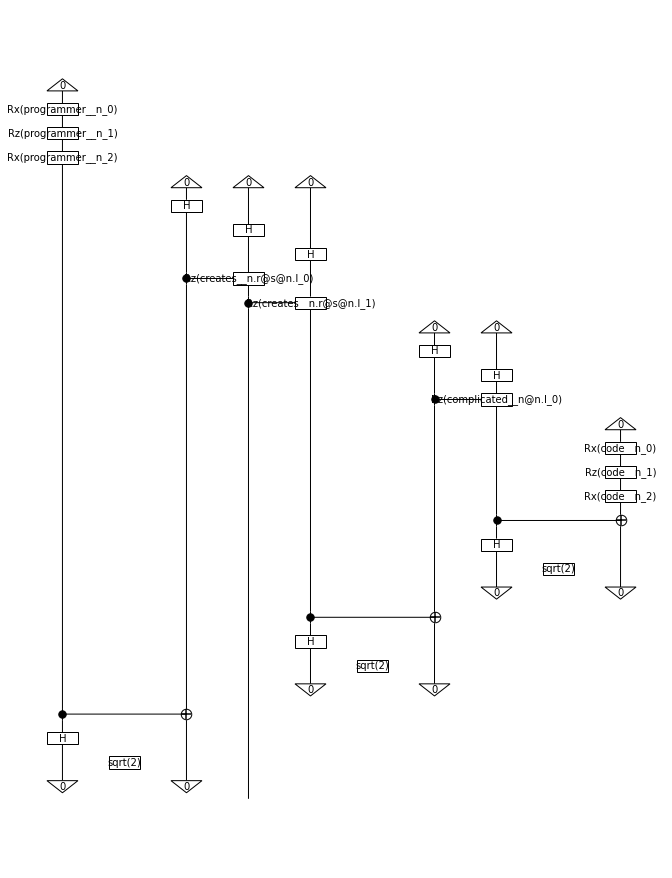

In [9]:
ansatz = IQPAnsatz({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3) 

train_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in train_diagrams]
# dev_circuits =  [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in dev_diagrams]
test_circuits = [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in test_diagrams]

train_circuits[0][0].draw(figsize=(9, 12))

## The following circuit is formed using the new ansatz. This is the same circuit as above except all the Rx gates have been replace with Ry gates.

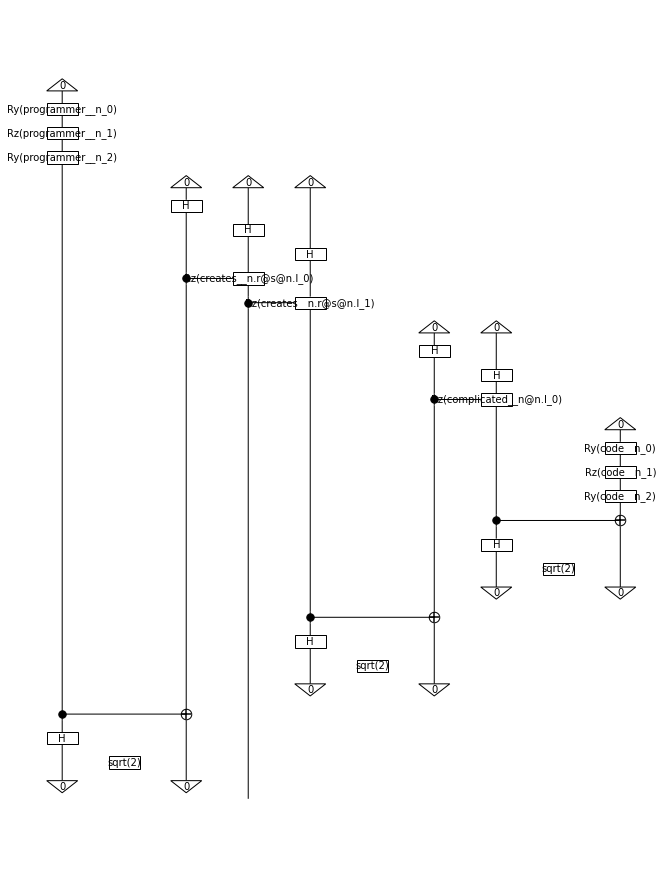

In [19]:
ansatz_new = IQPAnsatz_new({AtomicType.NOUN: 1, AtomicType.SENTENCE: 1},
                   n_layers=1, n_single_qubit_params=3) 

train_circuits1 = [[ansatz_new(diagram[0]), ansatz_new(diagram[1])] for diagram in train_diagrams]
# dev_circuits =  [[ansatz(diagram[0]), ansatz(diagram[1])] for diagram in dev_diagrams]
test_circuits1 = [[ansatz_new(diagram[0]), ansatz_new(diagram[1])] for diagram in test_diagrams]

train_circuits1[0][0].draw(figsize=(9, 12))

## Create a model from the circuits using the default ansatz.

In [10]:
all_circuits = [d for d in flatten(train_circuits)] + [d for d in flatten(test_circuits)]

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

## Create a model from the circuits using the new ansatz.

In [21]:
all_circuits = [d for d in flatten(train_circuits1)] + [d for d in flatten(test_circuits1)]

model = NumpyModel.from_diagrams(all_circuits, use_jit=True)

## Define loss and accuracy functions

In [ ]:
def loss_func(y_hat, y):
    ## tensor product and binary cross-entropy loss function
    y_hat_new  = []
    y_new = []
    for i in range(0, len(y_hat), 2):
        tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
        y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
        y_new.append(y[i])
        #print(np.sum(res_new[i]))
    loss =  -np.sum(np.array(y_new) * np.log(y_hat_new)) / len(y_new) # binary cross-entropy loss
    
    return loss

def loss_func_1(y_hat, y):
    ## cosine similarity and mean squared error
    
    y_hat_new  = []
    y_new = []
    
    
    for i in range(0, len(y_hat), 2):
        cos_sim = np.dot(y_hat[i], y_hat[i+1])/(np.linalg.norm(y_hat[i])*np.linalg.norm(y_hat[i+1]))
        #cos_sim = np.dot(np.sqrt(y_hat[i]), np.sqrt(y_hat[i+1]))
        y_hat_new.append(cos_sim)
        y_new.append(y[i])
    
    loss = np.sum((np.array(y_new) - np.array(y_hat_new))**2)/len(y_new)
            
    return loss

def accuracy_func(y_hat, y):
    y_hat_new  = []
    y_new = []
    for i in range(0, len(y_hat), 2):
        tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
        y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
        y_new.append(y[i])
    
    acc = np.sum(np.round(y_hat_new) == y_new) / len(y_new) / 2  # half due to double-counting
    
    return acc


def accuracy_func_1(y_hat, y):
    y_hat_new  = []
    y_new = []
    
    for i in range(0, len(y_hat), 2):
        cos_sim = np.dot(y_hat[i], y_hat[i+1])/(np.linalg.norm(y_hat[i])*np.linalg.norm(y_hat[i+1]))
        #cos_sim = np.dot(np.sqrt(y_hat[i]), np.sqrt(y_hat[i+1]))
        theta = np.rad2deg(np.arccos(min(1.0, cos_sim)))
        if theta < 20:
            y_hat_new.append(1) 
        else:
            y_hat_new.append(0) 
        y_new.append(y[i])
    
    acc = 0
    for i,j in zip (y_hat_new, y_new):
        if i==j:
            acc += 1
            
    return acc/len(y_new)

## Define a trainer and create dataset from circuits to train and test the model 

In [29]:
trainer = QuantumTrainer(
    model,
    loss_function=loss_func,
    epochs=EPOCHS,
    optimizer=SPSAOptimizer,
    optim_hyperparams={'a': 0.05, 'c': 0.06, 'A':0.01*EPOCHS},
    evaluate_functions={'acc': accuracy_func},
    evaluate_on_train=True,
    verbose = 'text',
    seed=SEED
)

In [13]:
train_dataset = Dataset([d for d in flatten(train_circuits)], np.repeat(train_labels, 2, axis=0),  batch_size=BATCH_SIZE*2, shuffle=False)

## With defualt ansatz

In [14]:
trainer.fit(train_dataset, logging_step=20)

Epoch 1:    train/loss: 0.7098   valid/loss: -----   train/acc: 0.5125   valid/acc: -----
Epoch 20:   train/loss: 0.6635   valid/loss: -----   train/acc: 0.6250   valid/acc: -----
Epoch 40:   train/loss: 0.6338   valid/loss: -----   train/acc: 0.6750   valid/acc: -----
Epoch 60:   train/loss: 0.5913   valid/loss: -----   train/acc: 0.7250   valid/acc: -----
Epoch 80:   train/loss: 0.5565   valid/loss: -----   train/acc: 0.7375   valid/acc: -----
Epoch 100:  train/loss: 0.5223   valid/loss: -----   train/acc: 0.8875   valid/acc: -----
Epoch 120:  train/loss: 0.4928   valid/loss: -----   train/acc: 0.8875   valid/acc: -----
Epoch 140:  train/loss: 0.4644   valid/loss: -----   train/acc: 0.9125   valid/acc: -----
Epoch 160:  train/loss: 0.4419   valid/loss: -----   train/acc: 0.9375   valid/acc: -----
Epoch 180:  train/loss: 0.3773   valid/loss: -----   train/acc: 0.9625   valid/acc: -----
Epoch 200:  train/loss: 0.3676   valid/loss: -----   train/acc: 0.9875   valid/acc: -----
Epoch 220:

Test accuracy: 1.0


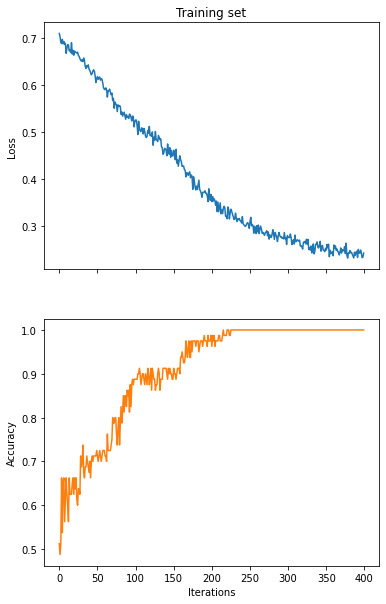

In [15]:
fig, (ax_t, ax_b) = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(6, 10))
ax_t.set_title('Training set')
#ax_tr.set_title('Development set')
ax_b.set_xlabel('Iterations')
#ax_br.set_xlabel('Iterations')
ax_b.set_ylabel('Accuracy')
ax_t.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_t.plot(trainer.train_epoch_costs, color=next(colours))
ax_b.plot(trainer.train_results['acc'], color=next(colours))
#ax_tr.plot(trainer.val_costs, color=next(colours))
#ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = accuracy_func(model([d for d in flatten(test_circuits)]), np.repeat(test_labels, 2, axis=0))
print('Test accuracy:', test_acc)

## Explicitlly check the test circuit output and accuracy of the model

In [16]:
y_hat, y = model([d for d in flatten(test_circuits)]), np.repeat(test_labels, 2, axis=0)

In [17]:
y_hat_new  = []
y_new = []
for i in range(0, len(y_hat), 2):
    tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
    y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
    y_new.append(y[i])

In [18]:
j = 0
for i, a in enumerate(y_new):
    print(a, y_hat_new[i]) ## a is the truth, y_hat_new is the prediction and y_hat is the circuit outputs for the pair of test sentences
    print(y_hat[j:j+2])
    j += 2

[1 0] [0.864477, 0.1355231]
[[0.90779227 0.09220774]
 [0.9468905  0.05310958]]
[0 1] [0.37364757, 0.6263524]
[[0.9825482  0.01745183]
 [0.36907792 0.63092214]]
[1 0] [0.8617217, 0.13827834]
[[0.07645271 0.92354727]
 [0.07298549 0.9270145 ]]
[1 0] [0.9116964, 0.08830368]
[[0.01066014 0.9893398 ]
 [0.07933498 0.9206651 ]]
[1 0] [0.91451705, 0.08548285]
[[0.07645271 0.92354727]
 [0.01066014 0.9893398 ]]
[0 1] [0.10529724, 0.8947028]
[[0.96216553 0.03783448]
 [0.07298549 0.9270145 ]]
[1 0] [0.9657545, 0.03424549]
[[0.01018444 0.98981553]
 [0.02456134 0.97543865]]
[1 0] [0.7137006, 0.28629938]
[[0.27655753 0.72344244]
 [0.02179941 0.9782006 ]]
[0 1] [0.048088424, 0.95191157]
[[0.01018444 0.98981553]
 [0.96130794 0.03869209]]
[0 1] [0.23439783, 0.7656022]
[[0.96216553 0.03783448]
 [0.21265471 0.7873453 ]]
[1 0] [0.8952315, 0.10476862]
[[0.9283814  0.07161867]
 [0.96130794 0.03869209]]
[0 1] [0.042936057, 0.957064]
[[0.96826315 0.03173687]
 [0.01195822 0.9880418 ]]
[1 0] [0.5887696, 0.4112304

## With new ansatz

In [30]:
train_dataset1 = Dataset([d for d in flatten(train_circuits1)], np.repeat(train_labels, 2, axis=0),  batch_size=BATCH_SIZE*2, shuffle=False)

In [31]:
trainer.fit(train_dataset1, logging_step=20) 

Epoch 1:    train/loss: 0.6850   valid/loss: -----   train/acc: 0.5500   valid/acc: -----
Epoch 20:   train/loss: 0.5914   valid/loss: -----   train/acc: 0.7250   valid/acc: -----
Epoch 40:   train/loss: 0.5523   valid/loss: -----   train/acc: 0.7500   valid/acc: -----
Epoch 60:   train/loss: 0.5491   valid/loss: -----   train/acc: 0.7750   valid/acc: -----
Epoch 80:   train/loss: 0.4872   valid/loss: -----   train/acc: 0.7750   valid/acc: -----
Epoch 100:  train/loss: 0.4774   valid/loss: -----   train/acc: 0.7750   valid/acc: -----
Epoch 120:  train/loss: 0.4687   valid/loss: -----   train/acc: 0.7375   valid/acc: -----
Epoch 140:  train/loss: 0.4493   valid/loss: -----   train/acc: 0.8875   valid/acc: -----
Epoch 160:  train/loss: 0.4334   valid/loss: -----   train/acc: 1.0000   valid/acc: -----
Epoch 180:  train/loss: 0.4616   valid/loss: -----   train/acc: 0.9125   valid/acc: -----
Epoch 200:  train/loss: 0.4153   valid/loss: -----   train/acc: 0.9625   valid/acc: -----
Epoch 220:

Test accuracy: 1.0


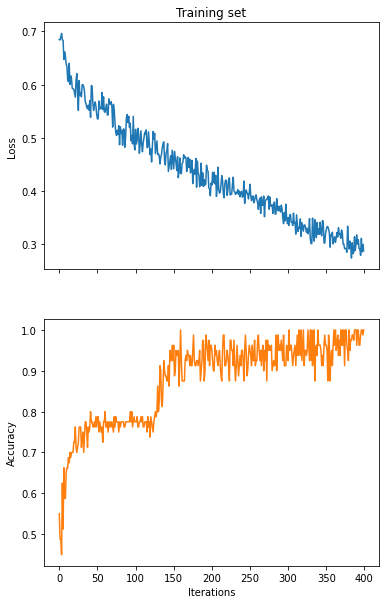

In [32]:
fig, (ax_t, ax_b) = plt.subplots(2, 1, sharex=True, sharey='row', figsize=(6, 10))
ax_t.set_title('Training set')
#ax_tr.set_title('Development set')
ax_b.set_xlabel('Iterations')
#ax_br.set_xlabel('Iterations')
ax_b.set_ylabel('Accuracy')
ax_t.set_ylabel('Loss')

colours = iter(plt.rcParams['axes.prop_cycle'].by_key()['color'])
ax_t.plot(trainer.train_epoch_costs, color=next(colours))
ax_b.plot(trainer.train_results['acc'], color=next(colours))
#ax_tr.plot(trainer.val_costs, color=next(colours))
#ax_br.plot(trainer.val_results['acc'], color=next(colours))

test_acc = accuracy_func(model([d for d in flatten(test_circuits1)]), np.repeat(test_labels, 2, axis=0))
print('Test accuracy:', test_acc)

## Explicitlly check the test circuit output and accuracy of the model

In [33]:
y_hat, y = model([d for d in flatten(test_circuits1)]), np.repeat(test_labels, 2, axis=0)

In [34]:
y_hat_new  = []
y_new = []
for i in range(0, len(y_hat), 2):
    tns_pd = np.tensordot(y_hat[i], y_hat[i+1], axes=0)
    y_hat_new.append([tns_pd[0][0] + tns_pd[1][1], tns_pd[0][1] + tns_pd[1][0]])
    y_new.append(y[i])

In [35]:
j = 0
for i, a in enumerate(y_new):
    print(a, y_hat_new[i]) ## a is the truth, y_hat_new is the prediction and y_hat is the circuit outputs for the pair of test sentences
    print(y_hat[j:j+2])
    j += 2

[1 0] [0.5101041, 0.48989585]
[[0.47796333 0.5220367 ]
 [0.27074268 0.7292573 ]]
[0 1] [0.40133357, 0.59866655]
[[0.37955472 0.6204453 ]
 [0.9095904  0.09040961]]
[1 0] [0.800869, 0.19913095]
[[0.9553843  0.04461568]
 [0.8303463  0.16965371]]
[1 0] [0.8606616, 0.1393384]
[[0.87941056 0.12058948]
 [0.975292   0.02470797]]
[1 0] [0.8455552, 0.1544448]
[[0.9553843  0.04461568]
 [0.87941056 0.12058948]]
[0 1] [0.17704554, 0.82295454]
[[0.011188   0.988812  ]
 [0.8303463  0.16965371]]
[1 0] [0.92118454, 0.07881543]
[[0.9382158  0.0617842 ]
 [0.9805675  0.01943247]]
[1 0] [0.8009127, 0.19908723]
[[0.83146405 0.16853596]
 [0.9539146  0.04608537]]
[0 1] [0.06721541, 0.9327847]
[[0.9382158  0.0617842 ]
 [0.00619696 0.9938031 ]]
[0 1] [0.12783685, 0.8721632]
[[0.011188   0.988812  ]
 [0.8806813  0.11931872]]
[1 0] [0.5170205, 0.4829796]
[[0.48276597 0.5172341 ]
 [0.00619696 0.9938031 ]]
[0 1] [0.053531166, 0.9464688]
[[0.01172132 0.9882787 ]
 [0.95718646 0.0428135 ]]
[1 0] [0.8260376, 0.17396232